In [1]:
from collections import Counter
import numpy as np
from numpy import genfromtxt
import scipy.io
from scipy import stats
import random
import pandas as pd
from statistics import mode
import pydot

In [2]:
features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription",
            "creative", "height", "featured", "differ", "width", "other",
            "energy", "business", "message", "volumes", "revision", "path",
            "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
            "square_bracket", "ampersand"
        ]
assert len(features) == 32
class_names = ["Ham", "Spam"]

In [21]:
class DecisionTree:
    
    class Node:
        def __init__(self, split_rule, left, right, label, is_leaf):
            self.split_rule = split_rule
            self.left = left
            self.right = right
            self.label = label
            self.is_leaf = is_leaf # 1 = stop 
            
        def __repr__(self):
            """
            TODO: one way to visualize the decision tree is to write out a __repr__ method
            that returns the string representation of a tree. Think about how to visualize
            a tree structure. You might have seen this before in CS61A.
            """
            def viz(Node, prefix, symbol):
                if not Node:
                    return prefix + '[]'
                if Node.is_leaf == 1:
                    return(prefix + '(Therefore the email was: '+ class_names[Node.label] + ')')
                else:
                    ret = (prefix + '[Feature: '+ features[Node.split_rule[0]] + 
                           ', Threshold: '+symbol+ str(Node.split_rule[1]) + ']')
                    ret += '\n' + viz(Node.left, prefix + '\t','<=') + '\n' + viz(Node.right, prefix + '\t','>')
                    return ret
                
            return viz(self, "",'<=')
    
        
    def __init__(self, max_depth = 200):
        self.max_depth = max_depth
        
    def max_count(self, array):
        return stats.mode(array, nan_policy='omit')[0][0]
    

    def entropy(self,y):
        p = y / (np.sum(y)+1e-10)
        return -p.dot(np.log2(p+1e-10))
    

    def entropy_impurity(self,left_y_freq, right_y_freq):
        Sl = np.sum(left_y_freq)
        Sr = np.sum(right_y_freq)
        return (Sl * self.entropy(left_y_freq) + Sr * self.entropy(right_y_freq)) / (Sl+Sr)
    

    def information_gain(self,left_y_freq, right_y_freq):
        total = left_y_freq + right_y_freq
        if self.entropy(total) == 0: # see if it is pure
            return -1
        else:
            infor_gain = self.entropy(total) - self.entropy_impurity(left_y_freq, right_y_freq)
        return infor_gain
    
#     @staticmethod
#     def gini(y): 
#         p = y / (np.sum(y)+1e-20)
#         gini = 1-np.sum(p**2)
#         return gini

#     @staticmethod
#     def gini_impurity(left_label_freq, right_label_freq): # useless
#         Sl = np.sum(left_label_freq)
#         Sr = np.sum(right_label_freq)
#         return (Sl * gini(left_label_freq) + Sr * gini(right_label_freq)) / (Sl+Sr)

#     @staticmethod 
#     def gini_purification(X, y, thresh):
#         """
#         TODO: implement a method that calculates reduction in impurity gain given a vector of features
#         and a split threshold
#         """
#         return 0
    
    def split(self, S, depth, random_f = -1, verbose = False): # recursively
        """
        TODO: implement a method that return a split of the dataset given an index of the feature and
        a threshold for it
        """
#         print((depth-1) * '    '+'Depth: '+ str(depth))
        if depth >= self.max_depth: 
#             print('label: '+ str(self.max_count(self.labels[S])))
            node = self.Node(left=None, right=None, split_rule=None, is_leaf=1, label=self.max_count(self.labels[S]))
            if verbose == True:
                print(repr(node))
            return node
        else:
            max_feature, max_thresh = self.segmenter(self.data[S, :], self.labels[S],random_f = random_f)
            
#             print((depth-1) * '    '+'depth:' + str(depth)  + ', feature index: ' + str(max_feature) +', threshold: ' + str(max_thresh))
            Sl = [i for i in S if self.data[i, max_feature] <= max_thresh]
            Sr = [i for i in S if self.data[i, max_feature] > max_thresh]
#             print((depth-1) * '    '+"left group: " + str(len(Sl)) + ', right group: ' + str(len(Sr)))
            if len(Sl) <= 5 or len(Sr) <= 5: 
#                 print('label: '+ str(self.max_count(self.labels[S])))
                node = self.Node(left=None, right=None, split_rule=None, is_leaf=1, label=self.max_count(self.labels[S]))
                if verbose == True:
                    print(repr(node))
                return node
            else:
                node = self.Node(left=self.split(Sl, depth+1, random_f), right=self.split(Sr,depth+1,random_f), split_rule = (max_feature, max_thresh), is_leaf=0, label=None)
                if verbose == True:
                    print(repr(node))
                return node
    
    
    def iter_thresh(self, X, y):
        """
        A method that return the max threshold and max information gain for one feature
        """
        row_f = sorted(set(X)) 
        col_l = set(y)
        freq_matrix = np.zeros([len(row_f), len(col_l)])
        for i, j in enumerate(row_f):
            for k, l in enumerate(col_l):
                freq_matrix[i, k] = len(y[np.where(y[np.where(X==j)]==l)])
        all_thresh = np.array(row_f[1:] + row_f[-1:]) / 2.
        left_freq = np.zeros([len(col_l)])
        right_freq = np.sum(freq_matrix, axis=0)
        left_freq_sum = 0
        max_thresh = all_thresh[0]
        
        max_gain = self.information_gain(left_freq, right_freq)
        for i, thresh in enumerate(all_thresh):
            left_freq += freq_matrix[i, :]
            right_freq -= freq_matrix[i, :]
            gain = self.information_gain(left_freq, right_freq)
            if gain > max_gain:
                max_gain = gain
                max_thresh = thresh
        return max_thresh, max_gain
    
    
    def segmenter(self, X, y, random_f = -1):
        """
        TODO: compute entropy gain for all single-dimension splits,
        return the feature and the threshold for the split that
        has maximum gain
        """        
        x = X.shape[1]
        if random_f == -1:
            all_features = np.arange(x)
        else:
            all_features = np.random.choice(range(x), random_f)
            
        all_features = np.arange(x)
        max_gain = 1e-10
        max_thresh = 0
        max_feature = 0
        for i in all_features:
            thresh, gain = self.iter_thresh(X[:, i], y)
            if gain > max_gain:
                max_gain = gain
                max_thresh = thresh
                max_feature = i
        return max_feature, max_thresh
    
    
    def fit(self, X, y, random_f = -1, verbose = True):
        """
        TODO: fit the model to a training set. Think about what would be 
        your stopping criteria
        """
        self.data = X
        self.labels = y
        S = np.array(range(len(y)))
        self.root = self.split(S, 1 , random_f = random_f, verbose = verbose)
        return self

    
    def predict(self, X, T = 0):
        """
        TODO: predict the labels for input data 
        """
        if T == 1:  # T = 1, for random forest
            X = np.reshape(X, [1, len(X)])
            row_num = 1
        else:
            row_num = X.shape[0]
        labels = np.zeros(row_num)    
        depth = 0    
        for i in range(row_num): 
            current_node = self.root
            while current_node.is_leaf == 0: 
                feature = current_node.split_rule[0]
                thresh = current_node.split_rule[1]
                if X[i,:][feature] <= thresh:
                    current_node = current_node.left
                else:
                    current_node = current_node.right
            depth += 1
            labels[i] = current_node.label
        return labels
    
    def accuracy(self, X, y_val, T = 0):
        y_pred = self.predict(X, T = T)
        len_y = float(len(y_pred))
        return np.sum(y_pred == y_val) / len_y
    

In [22]:
class RandomForest():
    
    def __init__(self, n_trees=20, n_sample=1000, random_f=-1, max_depth=200):
        """
        TODO: initialization of a random forest
        """
        self.n_trees = n_trees
        self.n_sample = n_sample
        self.random_f = random_f
        self.max_depth = max_depth
        self.trees = np.array([DecisionTree(max_depth)] * n_trees)
        
    def fit(self, X, y):
        """
        TODO: fit the model to a training set.
        """
        if self.random_f == -1:
            self.random_f = int(np.sqrt(X.shape[1])) 
        results = np.zeros(self.n_trees, dtype=object)
        for i, dt in enumerate(self.trees):
            print('#%d. tree' % i)
            idx = np.random.choice(range(len(X)), self.n_sample)
            sub_X = X[idx, :]
            sub_y = y[idx]
            results[i] = dt.fit(sub_X, sub_y, random_f=self.random_f, verbose = False)
        self.trees = results

    def predict(self, X, T = 1):
        """
        TODO: predict the labels for input data 
        """
        row_num = X.shape[0]
        labels = []    
        for i in range(row_num):
            pred = np.zeros(self.n_trees)
            for j, dt in enumerate(self.trees):
                pred[j] = dt.predict(X[i, :], T = T)
            labels.append(dt.max_count(pred))
        return labels
    
    def accuracy(self, X, y_val, T = 1):
        y_pred = self.predict(X,T = T)
        N = float(len(y_pred))
        return np.sum(y_pred == y_val) / N
     

In [5]:
def normalization(X):
    Xn = np.zeros(X.shape)
    for i in range(X.shape[0]):
        x = X[i, :]
        Xn[i, :] = (x- np.min(x)/(np.max(x)-np.min(x)))
    return Xn

In [25]:
# load spam data
spam = scipy.io.loadmat('datasets/spam-dataset/spam_data.mat')
train_X = spam['training_data']
train_y = spam['training_labels'].ravel()
test_X = spam['test_data']

In [26]:
# split data
idx = np.random.choice(range(len(train_y)), int(len(train_y)), replace=False)
train_size = int(len(train_X)*0.8)
X_train = train_X[idx,:][:train_size,:]
y_train = train_y[idx][:train_size]
X_val = train_X[idx,:][train_size:,:]
y_val = train_y[idx][train_size:]

In [29]:
# try training
dt = DecisionTree(16)
dt.fit(X_train, y_train, verbose = True)
print(repr(dt)) 
train_acc = dt.accuracy(X_train, y_train)
print('Training accuracy: ', train_acc)
val_acc = dt.accuracy(X_val, y_val)
print('Validation accuracy: ', val_acc)

[Feature: exclamation, Threshold: <=0.5]
	[Feature: meter, Threshold: <=0.5]
		[Feature: parenthesis, Threshold: <=0.5]
			[Feature: ampersand, Threshold: <=0.5]
				[Feature: volumes, Threshold: <=0.5]
					[Feature: semicolon, Threshold: <=0.5]
						[Feature: pain, Threshold: <=0.5]
							[Feature: square_bracket, Threshold: <=0.5]
								[Feature: prescription, Threshold: <=0.5]
									[Feature: energy, Threshold: <=0.5]
										[Feature: drug, Threshold: <=0.5]
											(Therefore the email was: Ham)
											(Therefore the email was: Spam)
										[Feature: energy, Threshold: >1.0]
											[Feature: dollar, Threshold: <=0.5]
												(Therefore the email was: Ham)
												(Therefore the email was: Ham)
											(Therefore the email was: Ham)
									(Therefore the email was: Spam)
								(Therefore the email was: Spam)
							(Therefore the email was: Spam)
						[Feature: dollar, Threshold: >0.5]
							[Feature: square_bracket, Threshold: <=0.5]
						

In [32]:
accuracy_list = []
for i in range(40):
    print(str(i+1))
    dt = DecisionTree(i+1)
    dt.fit(X_train, y_train, verbose = False)
    acc = dt.accuracy(X_val, y_val)
    accuracy_list.append(acc)

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 


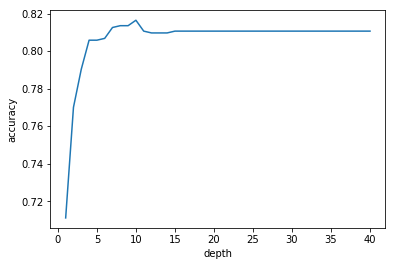

In [12]:
# accuracy_list
mylist = np.linspace(1,40,40)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(mylist,accuracy_list)
plt.xlabel('depth')
plt.ylabel('accuracy')
fig.savefig('1-40depth-accuracy-dt.png')

# when the depth is equal or larger than 15, the validation accuracy is stable and the largest

In [34]:
rf = RandomForest(n_trees=20, n_sample=len(y_train), random_f=-1, max_depth=20)
rf.fit(X_train, y_train) # use all data
train_acc = rf.accuracy(X_train,y_train)
print('Training accuracy: ', train_acc)
val_acc = rf.accuracy(X_val,y_val)
print('Validation accuracy: ', val_acc)

#0. tree
#1. tree
#2. tree
#3. tree
#4. tree
#5. tree
#6. tree
#7. tree
#8. tree
#9. tree
#10. tree
#11. tree
#12. tree
#13. tree
#14. tree
#15. tree
#16. tree
#17. tree
#18. tree
#19. tree
Training accuracy:  0.8300700991056321
Validation accuracy:  0.8241545893719807
